In [1]:
import numpy as np
from aix360.algorithms.protodash import ProtodashExplainer
import matplotlib.pyplot as plt
from torchvision.utils import make_grid
import torch

In [2]:
%run ../utils/__init__.py

## Load data

In [3]:
%run ../datasets/__init__.py

In [44]:
kwargs = {
    'dataset_type': 'test',
    'dataset_name': 'iu-x-ray',
    'image_size': (512, 512),
    'shuffle': True,
    'frontal_only': True,
}

dataloader = prepare_data_classification(**kwargs)
len(dataloader.dataset)

Loading iu-x-ray/test dataset...


384

## Load model

In [5]:
%run ../models/checkpoint/__init__.py

In [6]:
run_name = '0917_161952_iu-x-ray_mobilenet_lr1e-06_aug-0-cls0_size256'
debug = False

In [7]:
compiled_model = load_compiled_model_classification(run_name, debug=debug, device='cuda')
compiled_model.metadata

{'model_kwargs': {'model_name': 'mobilenet',
  'labels': ['No Finding',
   'Enlarged Cardiomediastinum',
   'Cardiomegaly',
   'Lung Lesion',
   'Lung Opacity',
   'Edema',
   'Consolidation',
   'Pneumonia',
   'Atelectasis',
   'Pneumothorax',
   'Pleural Effusion',
   'Pleural Other',
   'Fracture',
   'Support Devices'],
  'imagenet': True,
  'freeze': False,
  'gpool': 'max',
  'fc_layers': []},
 'opt_kwargs': {'lr': 1e-06},
 'hparams': {'loss_name': 'wbce', 'loss_kwargs': {}, 'batch_size': 100},
 'dataset_kwargs': {'dataset_name': 'iu-x-ray',
  'labels': None,
  'max_samples': None,
  'batch_size': 100,
  'image_size': [256, 256],
  'frontal_only': False},
 'dataset_train_kwargs': {'oversample': False,
  'oversample_label': None,
  'oversample_class': None,
  'oversample_ratio': None,
  'oversample_max_ratio': None,
  'augment': True,
  'augment_label': 0,
  'augment_class': 0,
  'augment_kwargs': {'crop': 0.8,
   'translate': 0.1,
   'rotation': 15,
   'contrast': 0.5,
   'brigh

## ProtoDash

### Random images

In [21]:
batch_size = 10
n_features = 15
images = np.random.random((batch_size, n_features))
images.shape

(10, 15)

### Load images

In [47]:
images = []
labels = []
for batch in dataloader:
    images.append(batch.image)
    labels.append(batch.labels)

images = torch.cat(images, dim=0)
labels = torch.cat(labels, dim=0)
images.size(), labels.size()

(torch.Size([384, 3, 512, 512]), torch.Size([384, 14]))

#### Raw pixels as features

In [18]:
batch_size = images.size()[0]
features = images.detach().cpu().view(batch_size, -1).numpy()
features.shape

(384, 196608)

#### CNN output as features

In [48]:
features = []

for batch in dataloader:
    feats = compiled_model.model(batch.image.to('cuda'), features=True).detach().cpu()
    feats = feats.view(feats.size()[0], -1)
    features.append(feats)
features = torch.cat(features, dim=0)
features.size()

torch.Size([384, 327680])

### Run proto

In [49]:
proto = ProtodashExplainer()
proto

In [50]:
%%time

weights, samples, other_values = proto.explain(features, features, 10)
samples.shape

CPU times: user 3.87 s, sys: 2.55 s, total: 6.42 s
Wall time: 892 ms


(10,)

In [51]:
def get_label(dataloader, item_label):
    dataset = dataloader.dataset
    multilabel = dataset.multilabel
    labels = dataset.labels
    
    if multilabel:
        return ','.join([
            disease
            for disease, presence in zip(labels, item_label)
            if presence
        ])
    else:
        return labels[l]

In [52]:
selected_images = []
selected_labels = []

for sample_idx in samples:
    image = images[sample_idx]
    selected_images.append(image)
    
    label = labels[sample_idx]
    label = get_label(dataloader, label)
    selected_labels.append(label)

selected_images = torch.stack(selected_images, dim=0)
selected_images.size(), list(enumerate(selected_labels))

(torch.Size([10, 3, 512, 512]),
 [(0, 'No Finding'),
  (1, 'Cardiomegaly'),
  (2, 'No Finding'),
  (3, 'No Finding'),
  (4, ''),
  (5, 'Lung Opacity'),
  (6, ''),
  (7, 'Lung Opacity'),
  (8, ''),
  (9, 'Lung Opacity,Pleural Other,Fracture')])

In [53]:
grid = make_grid(selected_images, normalize=True, scale_each=True, nrow=5)
grid = grid.permute(1, 2, 0)
grid.size()

torch.Size([1030, 2572, 3])

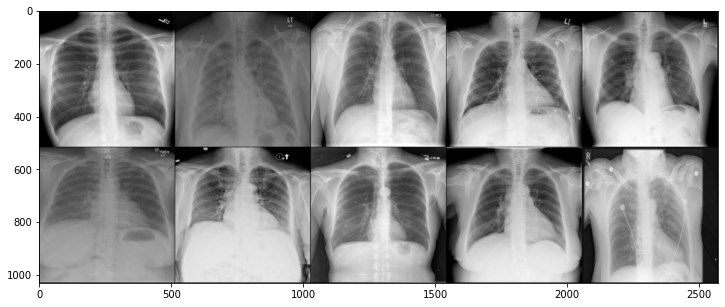

In [54]:
plt.figure(figsize=(15, 5))
plt.imshow(grid)

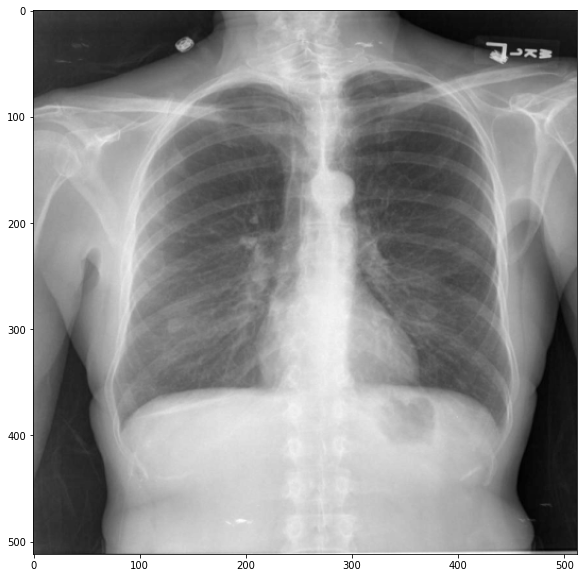

In [55]:
S_IDX = 7

plt.figure(figsize=(15, 10))
plt.imshow(tensor_to_range01(selected_images[S_IDX]).permute(1, 2, 0))